In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd
from xhistogram.xarray import histogram

import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5250294.datarmor0/parcels-502090/libparcels_random_d19f06e4-4571-47b7-97c8-9084393f12bf.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=6)

client = Client(cluster)

### Lagrangian spectra

In [3]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [4]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_raw_uv_mean0').persist()
df_Lspectra_mean1 = p.load_diagnostic('spectra_raw_uv_mean1').persist()
df_Lspectra_mean2 = p.load_diagnostic('spectra_raw_uv_mean2').persist()

### Eulerian spectra

In [3]:
sub = 2
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60.zarr'))
ds_E = ds_E.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 540, j: 540)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (face, j, i) bool dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 36, 1440), meta=np.ndarray>


In [ ]:
E = histogram(ds.lat4.rename('lat'), bins=[lat_bins], 
              weights=ds.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()

### Global spectra : 

In [4]:
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-70., 70., dl)

#### Lagrangian spectra binning

In [6]:
for ds_Lspectra in [df_Lspectra_mean0,df_Lspectra_mean1,df_Lspectra_mean2]:
    ds_Lspectra['lon'] = (ds_Lspectra['lon']+180)%360 - 180
    ds_Lspectra['lon_cut'] = ds_Lspectra['lon'].map_partitions(pd.cut, lon)
    ds_Lspectra['lat_cut'] = ds_Lspectra['lat'].map_partitions(pd.cut, lat)
    ds_Lspectra = ds_Lspectra.persist()

In [7]:
# Binning and averaging
uv_mean0 = df_Lspectra_mean0.groupby(['lat_cut']).mean().compute()
uv_mean1 = df_Lspectra_mean1.groupby(['lat_cut']).mean().compute()
uv_mean2 = df_Lspectra_mean2.groupby(['lat_cut']).mean().compute()

In [8]:
_ds = pd.melt(uv_mean0.set_index(uv_mean0.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
               ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()

In [ ]:
_ds = pd.melt(uv_mean1.set_index(uv_mean1.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean1'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean1'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean1

In [12]:
_ds = pd.melt(uv_mean2.set_index(uv_mean2.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean2'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean2'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean2

#### Eulerian spectra binning

In [5]:
ds_E['lat'] = 0*ds_E.face+ds_E.YC
ds_E['lat4'] = 0*ds_E.SSUV+ds_E.YC
ds_E = ds_E.persist()

In [ ]:
N = histogram(ds_E.lat, bins=[lat], 
              dim=['i', 'j', 'face']
             ).persist()

In [ ]:
E = histogram(ds_E.lat4.rename('lat'), bins=[lat], 
              weights=ds_E.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()

#### Plot

In [18]:
ds = ds.sortby('frequency')

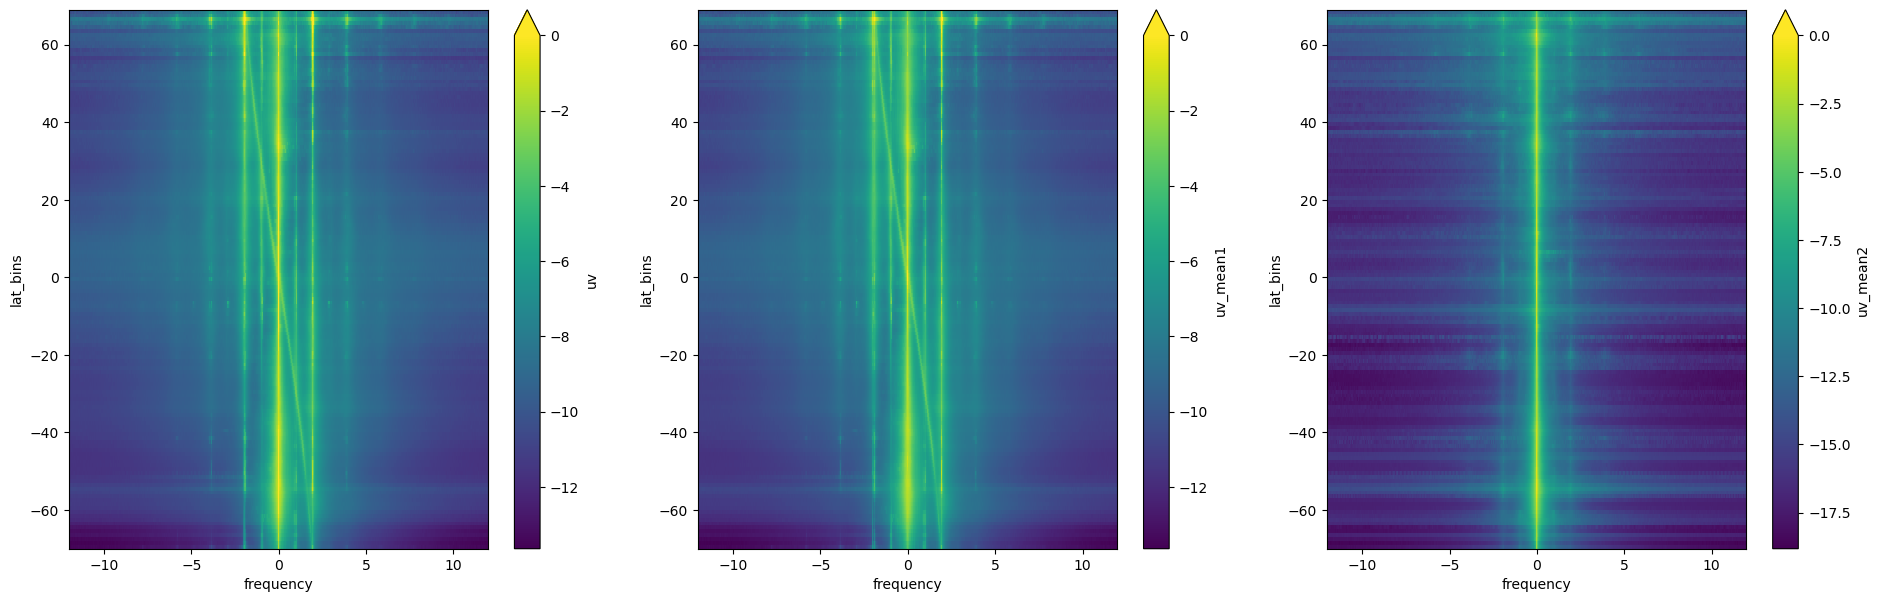

In [21]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log(ds[V]).plot(ax=ax,cmap='viridis',vmax=0)

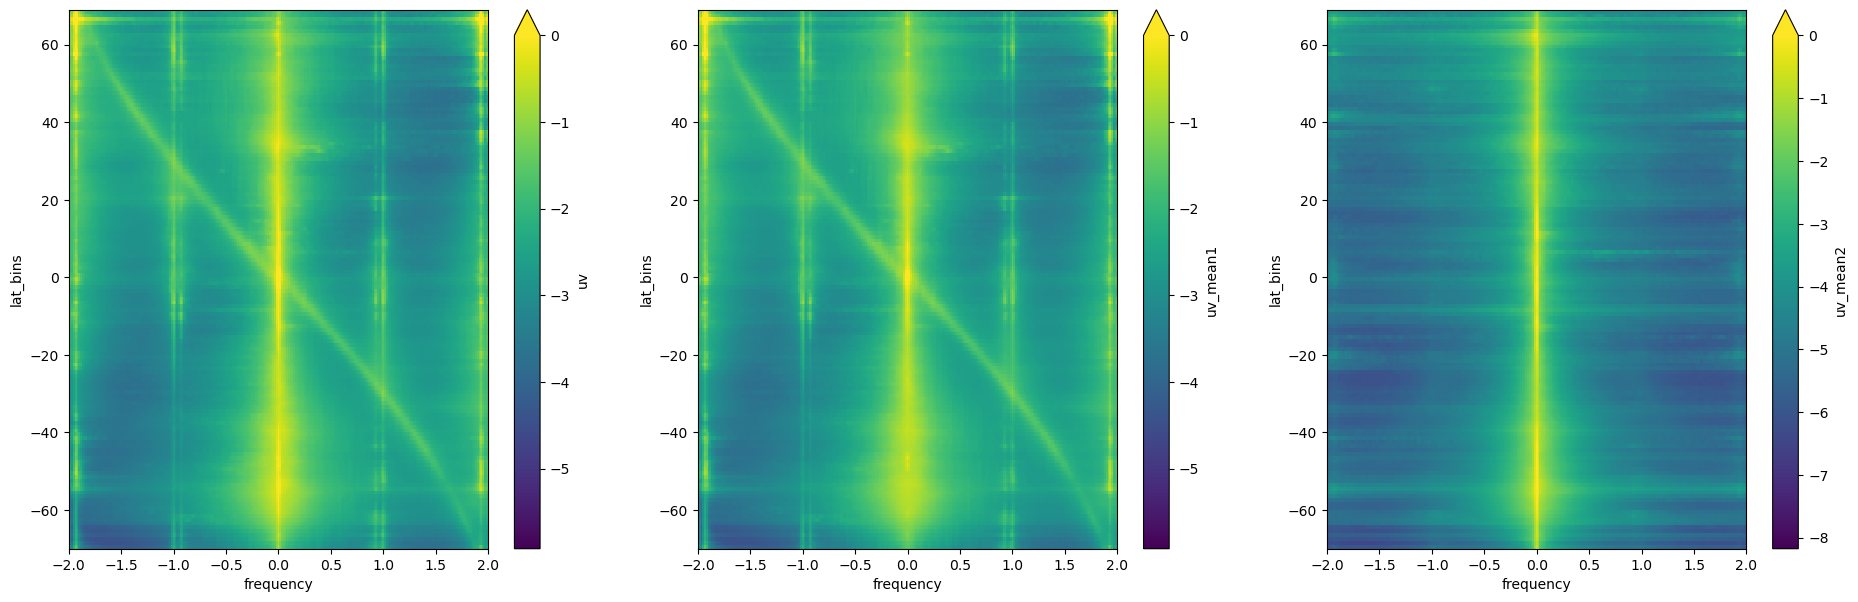

In [22]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log10(ds[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-2,2)

### Sites of interest

In [5]:
def binned_spectra_site(bbox,df,dl):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lat_cut']).mean().compute()
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=['lat_cut'],var_name='frequency')

    _ds['frequency'] = _ds['frequency'].astype('float64')
    ds_sub = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
                   ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    return ds_sub

#### California : 

In [6]:
bbox = [-128, -123, 33, 38] # small bbox

In [7]:
dl = 1.

In [8]:
df_mean0_Cal = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Cal = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Cal = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [9]:
ds_Cal = xr.merge([df_mean0_Cal,df_mean1_Cal.uv.rename('uv_mean1')
                   ,df_mean2_Cal.uv.rename('uv_mean2')])

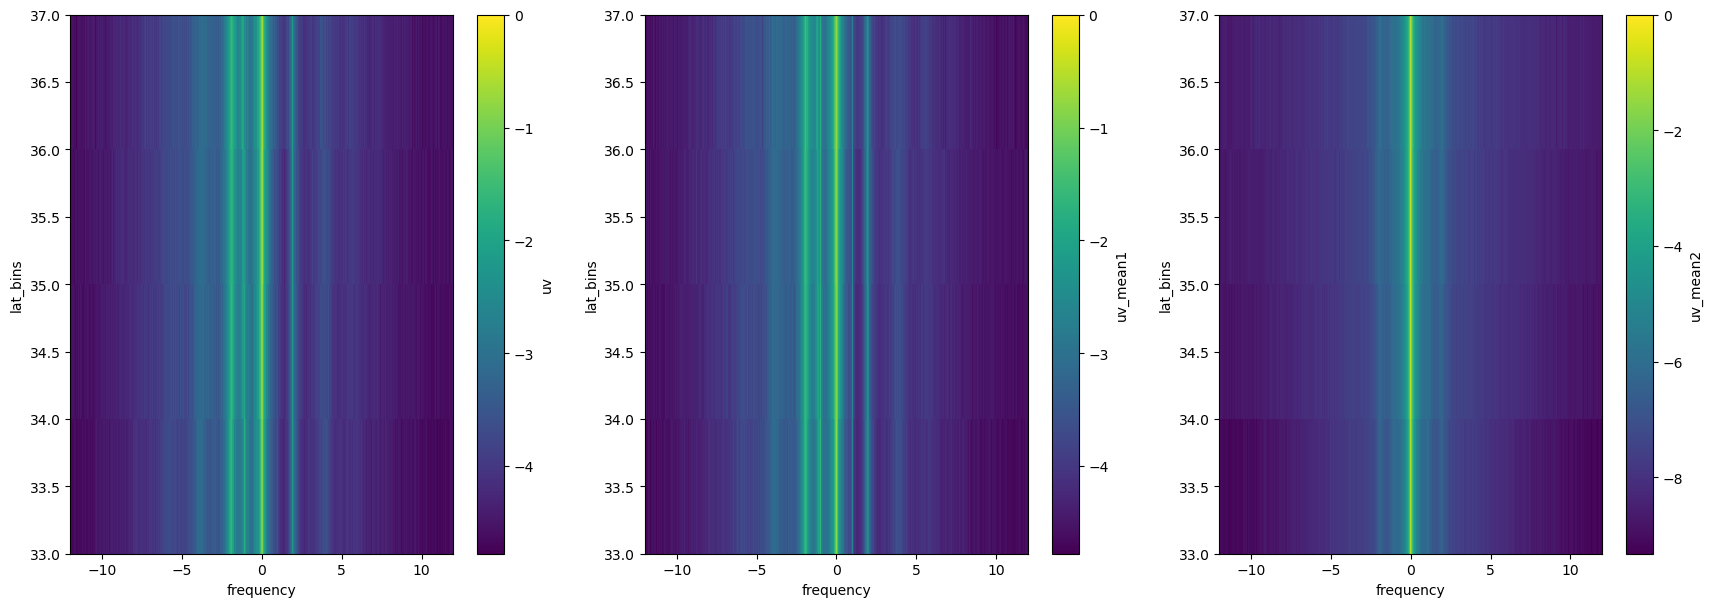

In [11]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)

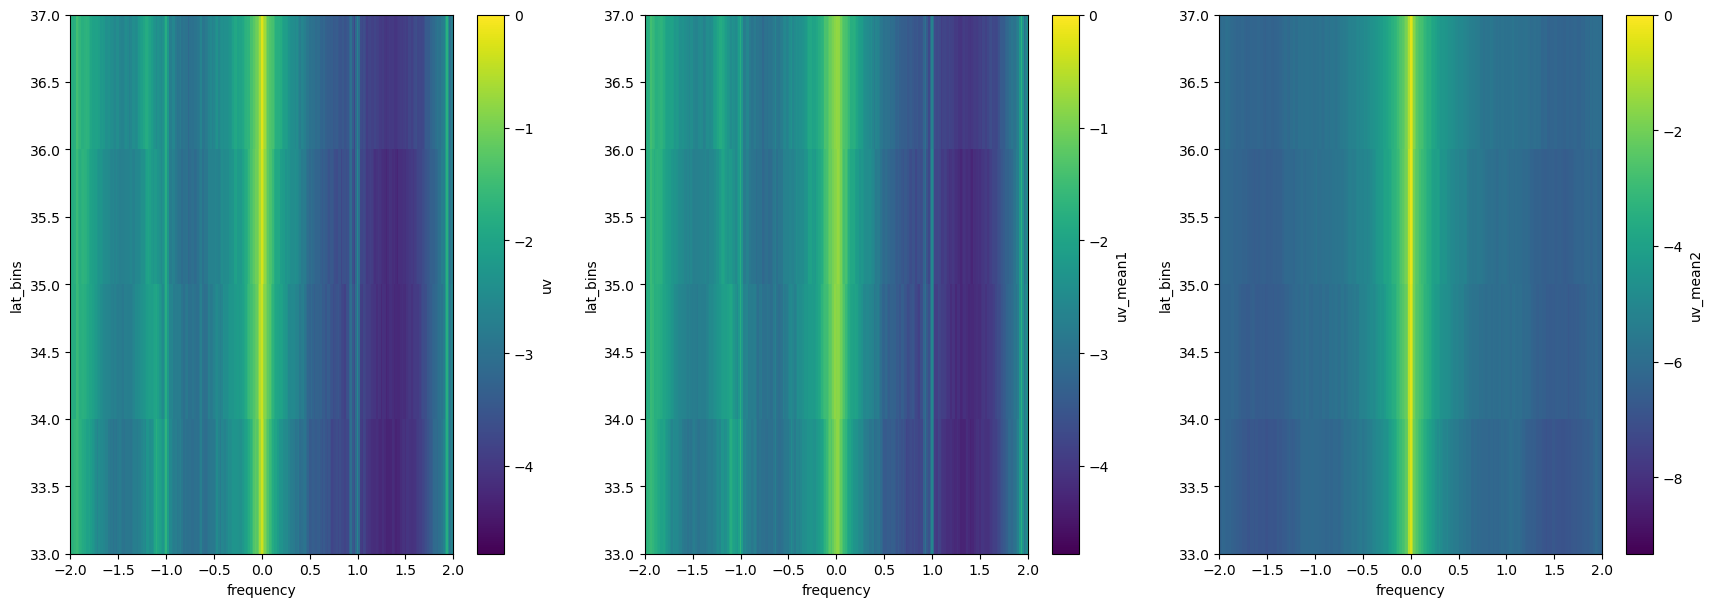

In [12]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)
    ax.set_xlim(-2,2)

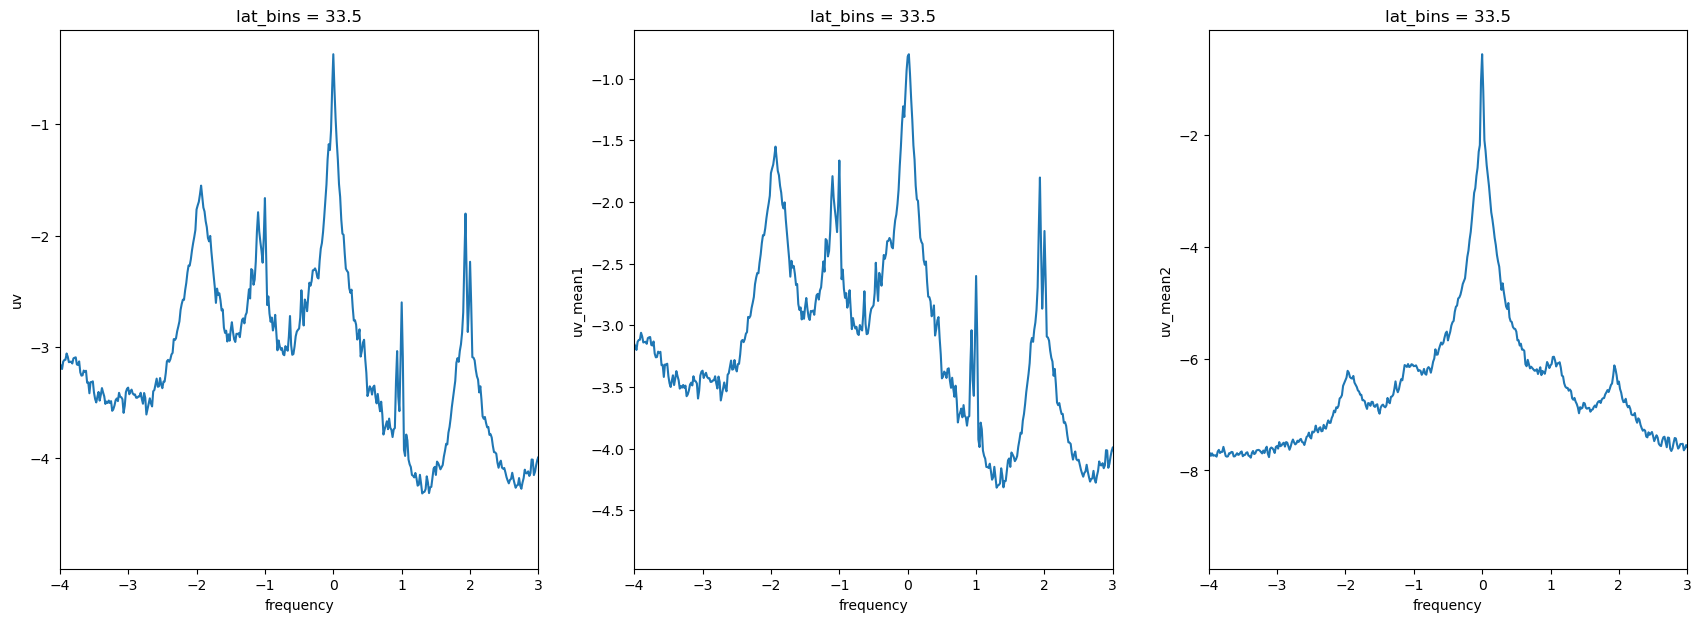

In [13]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).isel(lat_bins=0).plot(ax=ax)
    ax.set_xlim(-4,3)

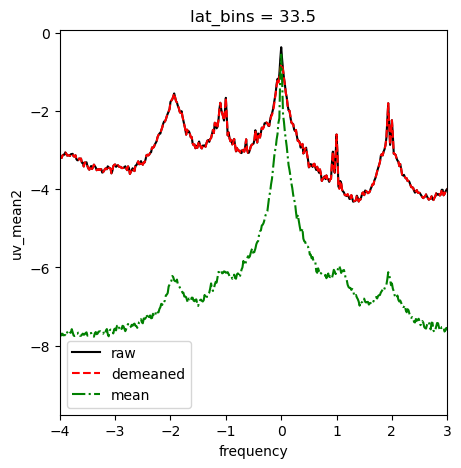

In [23]:
colors=['k','r','g']
styles=['-','--','-.']
fig, ax = plt.subplots(1,1,figsize=(5,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    np.log10(ds_Cal[V]).isel(lat_bins=0).plot(c=c,linestyle=style,ax=ax)
    ax.set_xlim(-4,3)
labels = ['raw', 'demeaned','mean']
ax.legend(labels)

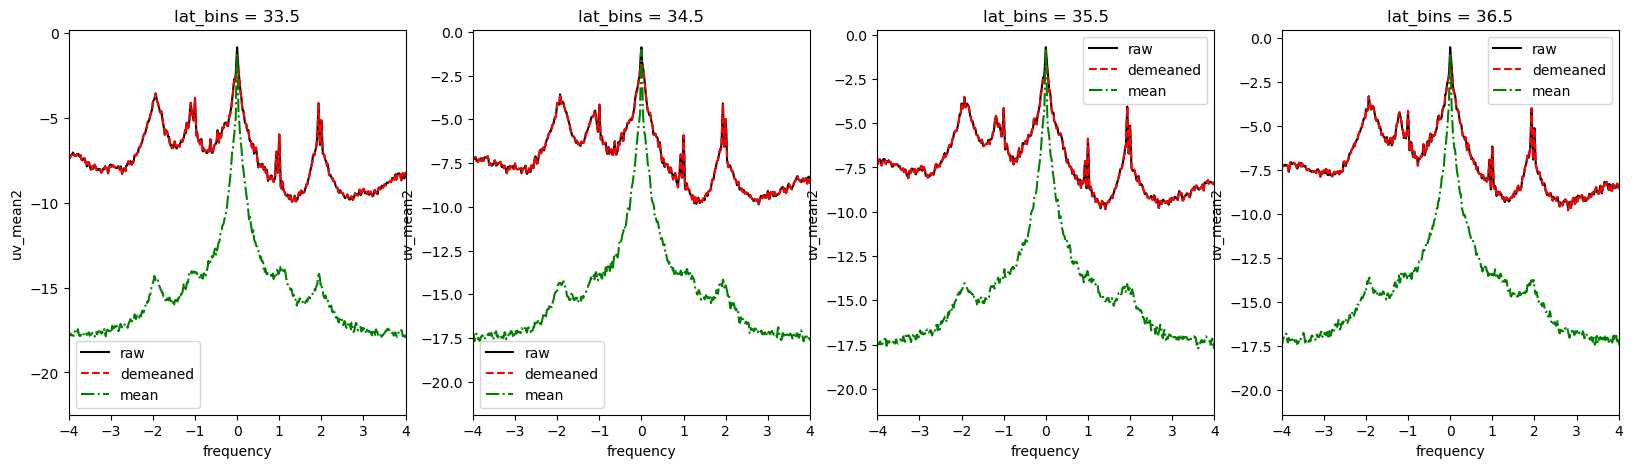

In [50]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_Cal.lat_bins.values),figsize=(len(ds_Cal.lat_bins.values)*5,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Cal[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

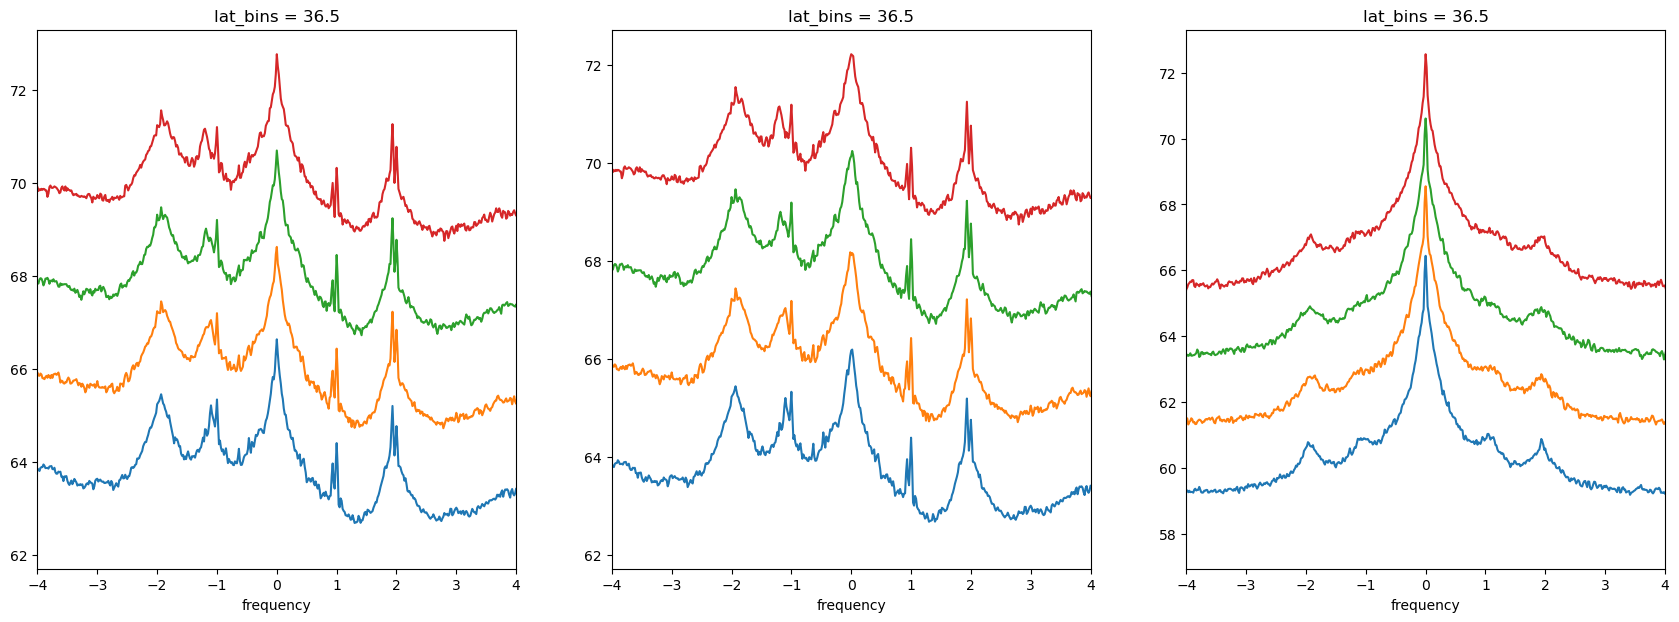

In [15]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    for i in ds_Cal.lat_bins:
        (np.log10(ds_Cal[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,4)

#### Mediterranean sea

In [51]:
bbox = [-2, 8, 36, 45] # large bbox


In [52]:
df_mean0_Med = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Med = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Med = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [53]:
ds_Med = xr.merge([df_mean0_Med,df_mean1_Med.uv.rename('uv_mean1')
                   ,df_mean2_Med.uv.rename('uv_mean2')])

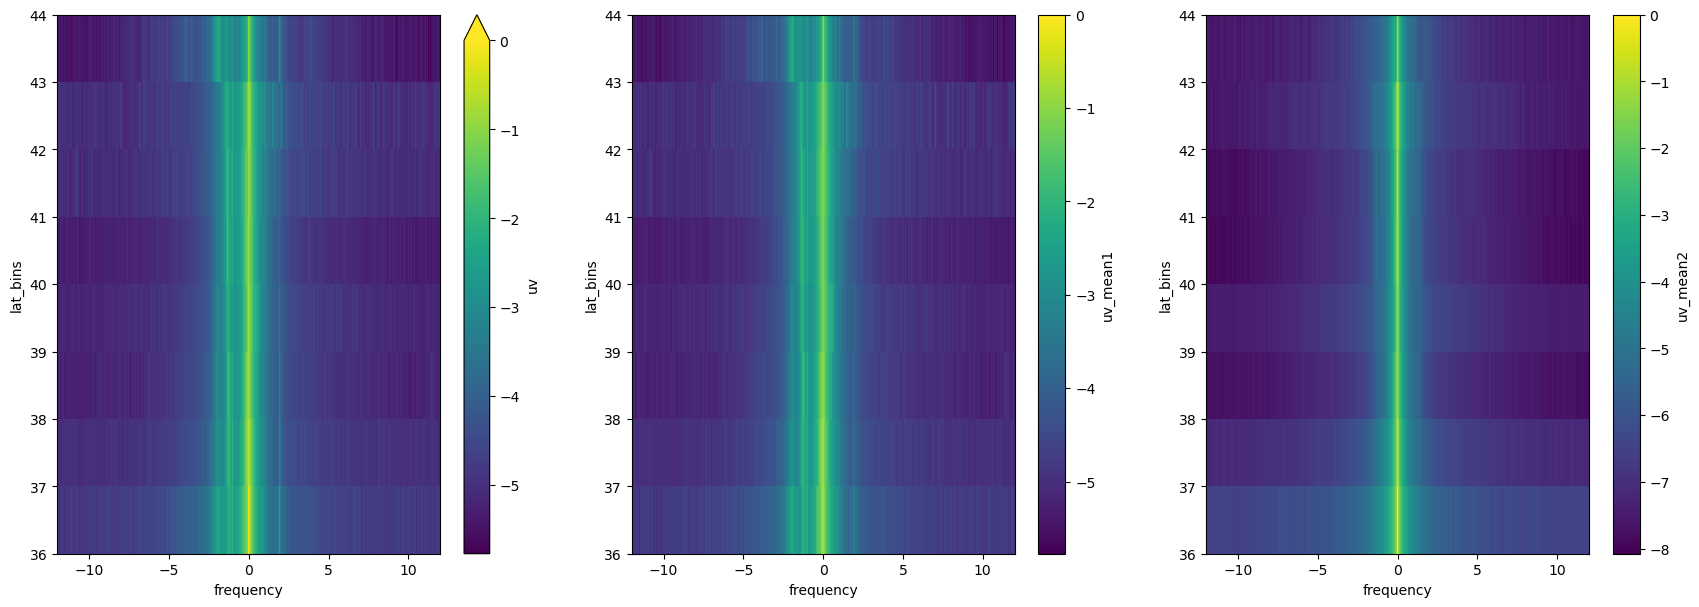

In [55]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)

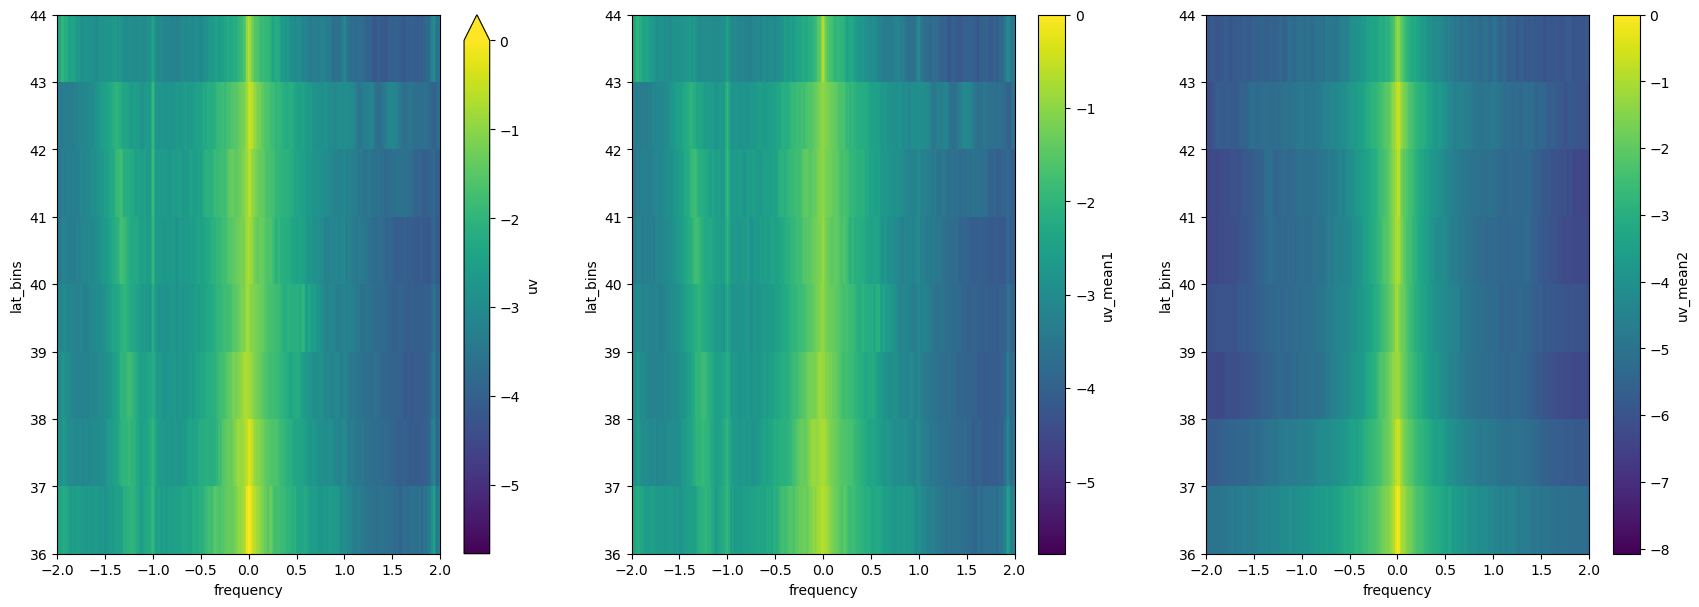

In [56]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-2,2)

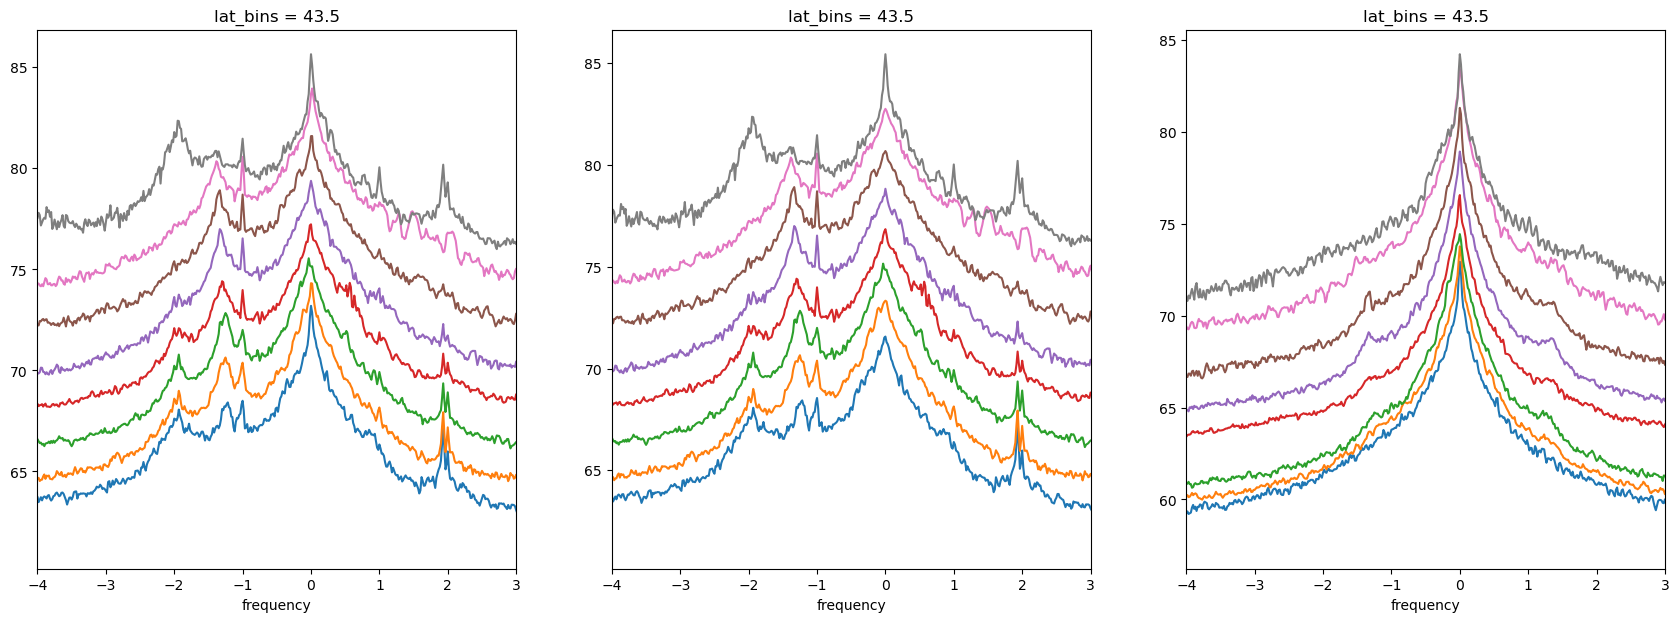

In [57]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    for i in ds_Med.lat_bins:
        (np.log(ds_Med[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

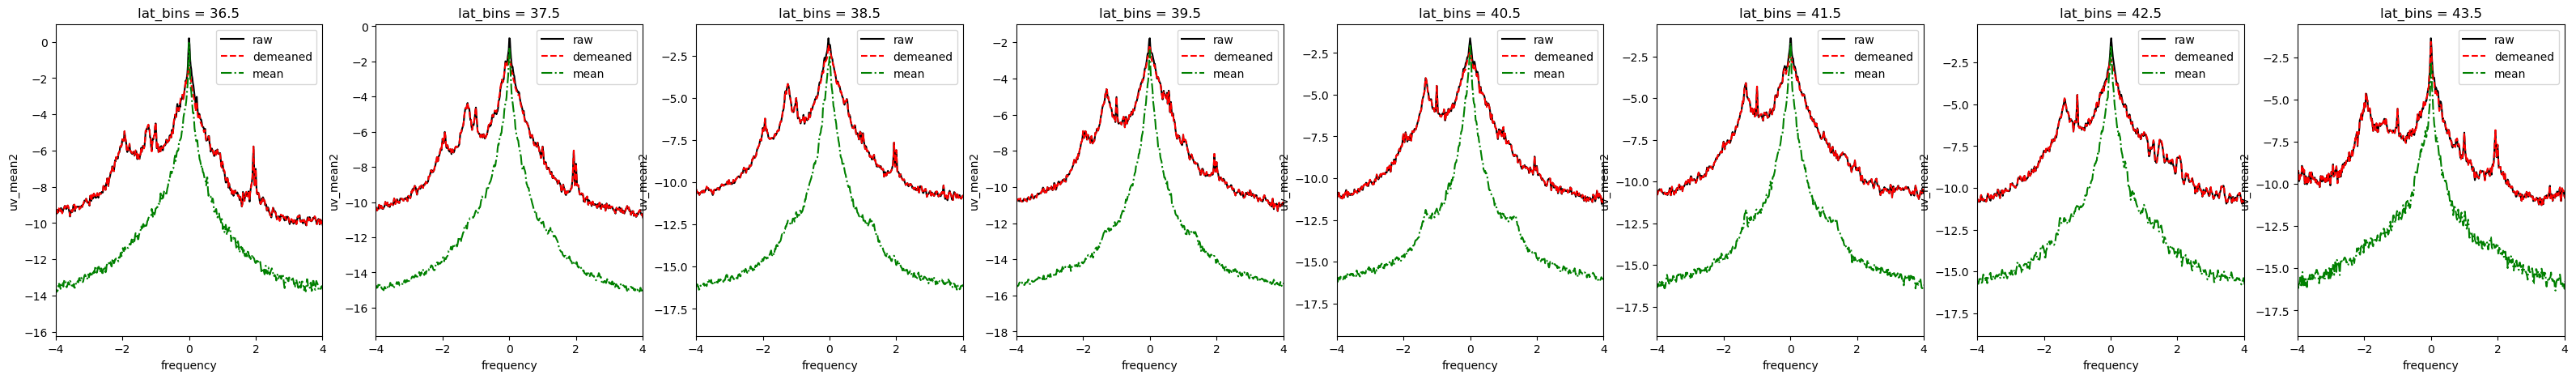

In [58]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_Med.lat_bins.values),figsize=(len(ds_Med.lat_bins.values)*5,5))
for V,c,style in zip(ds_Med.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Med[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

#### North west Australia

In [59]:
bbox = [120, 126, -20, -10]

In [60]:
df_mean0_NWA = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_NWA = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_NWA = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('getitem-7e504b75671dfd2ef1ecdd7ceee985f2', 16)"
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar

In [61]:
ds_NWA = xr.merge([df_mean0_NWA,df_mean1_NWA.uv.rename('uv_mean1')
                   ,df_mean2_NWA.uv.rename('uv_mean2')])

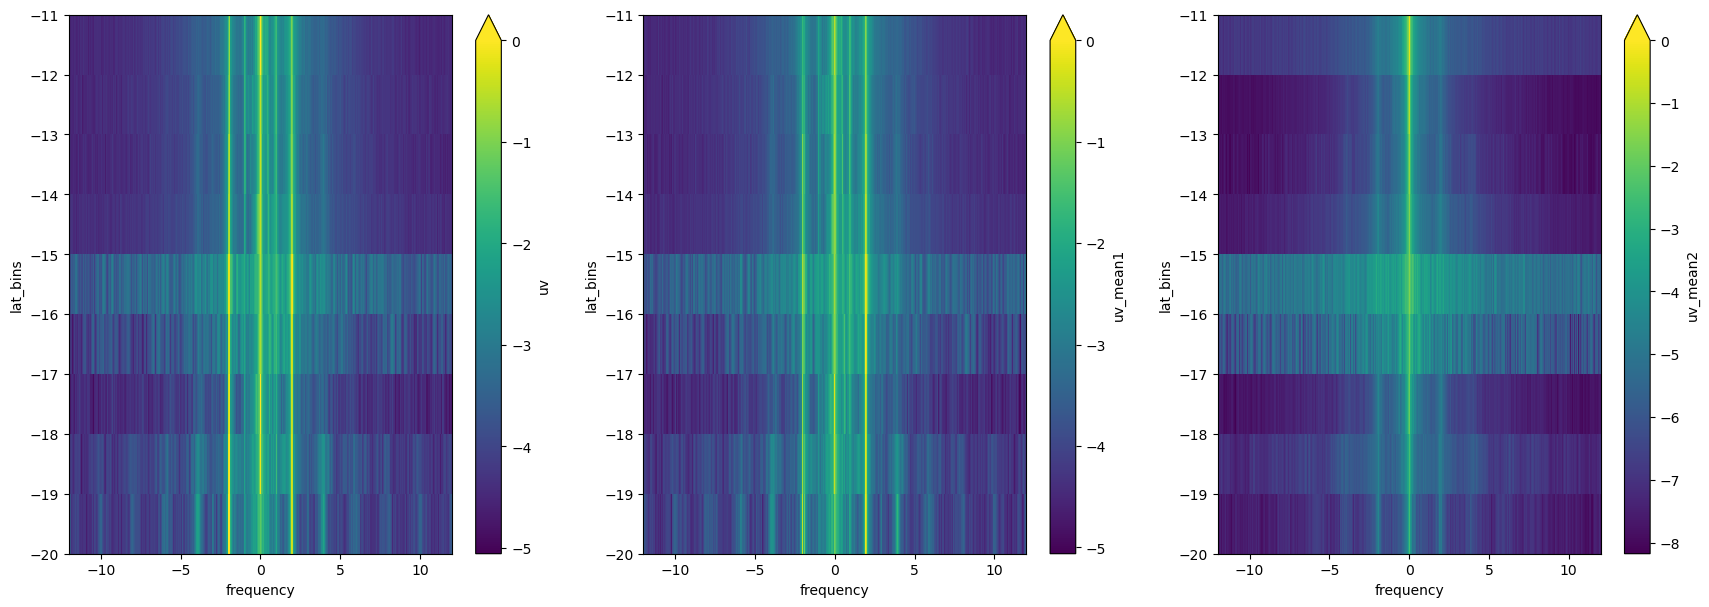

In [62]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)

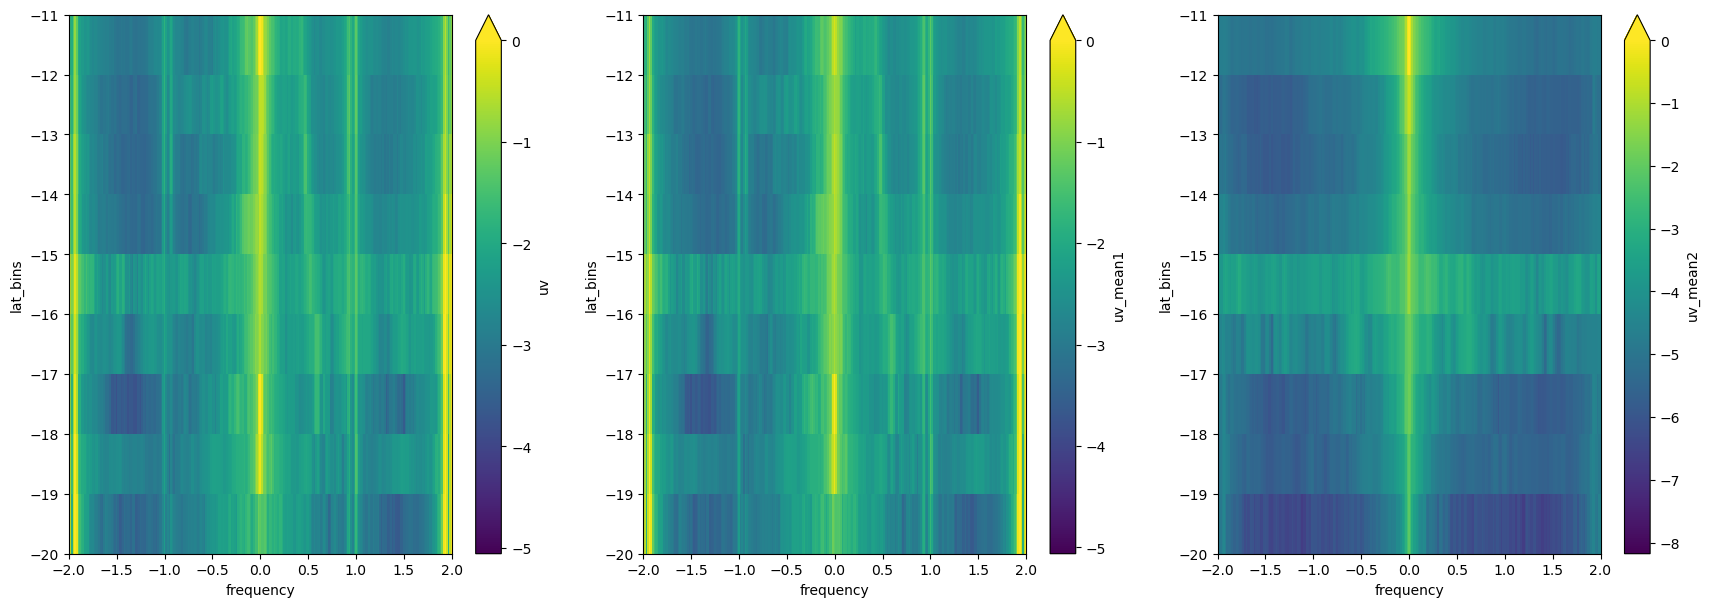

In [66]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-2,2)

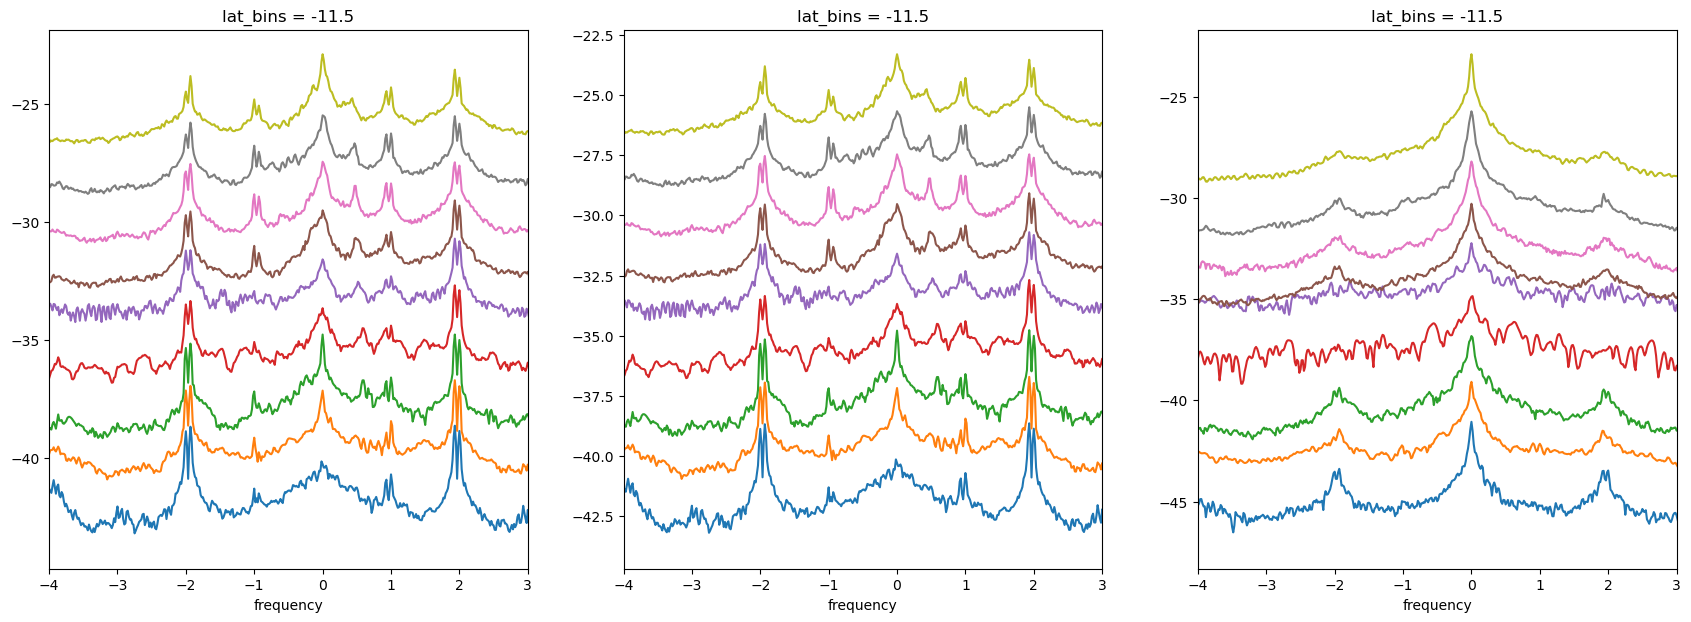

In [67]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    for i in ds_NWA.lat_bins:
        (np.log10(ds_NWA[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

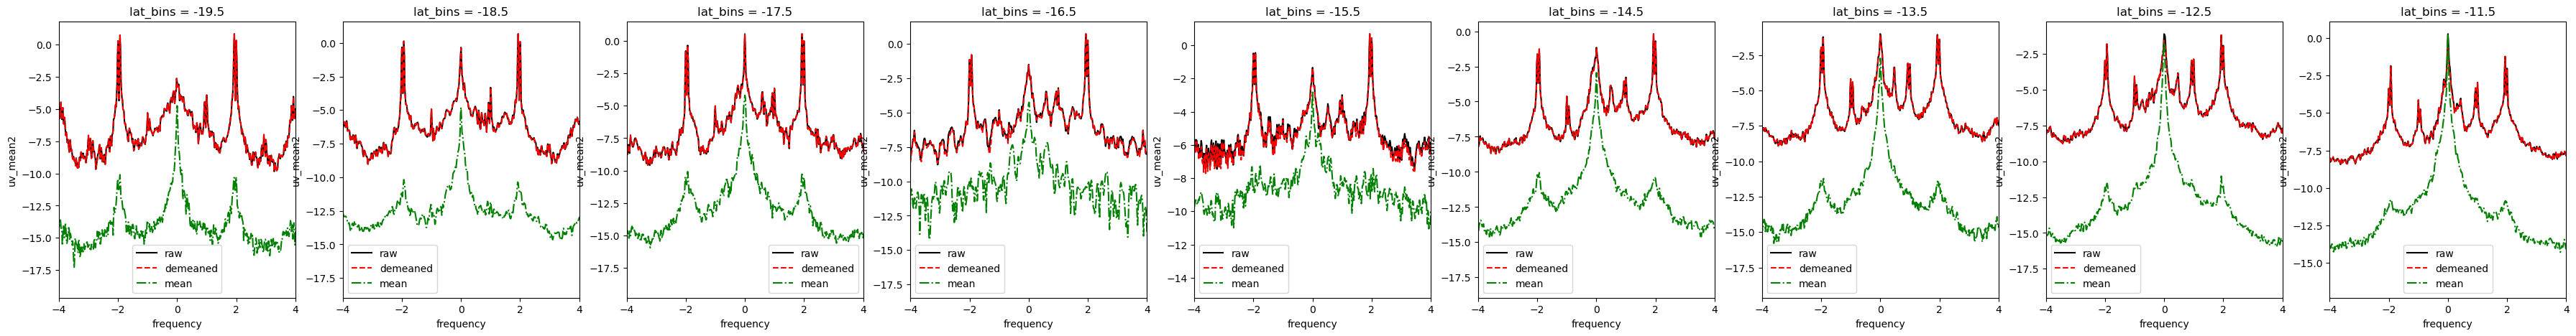

In [68]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_NWA.lat_bins.values),figsize=(len(ds_NWA.lat_bins.values)*5,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_NWA[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

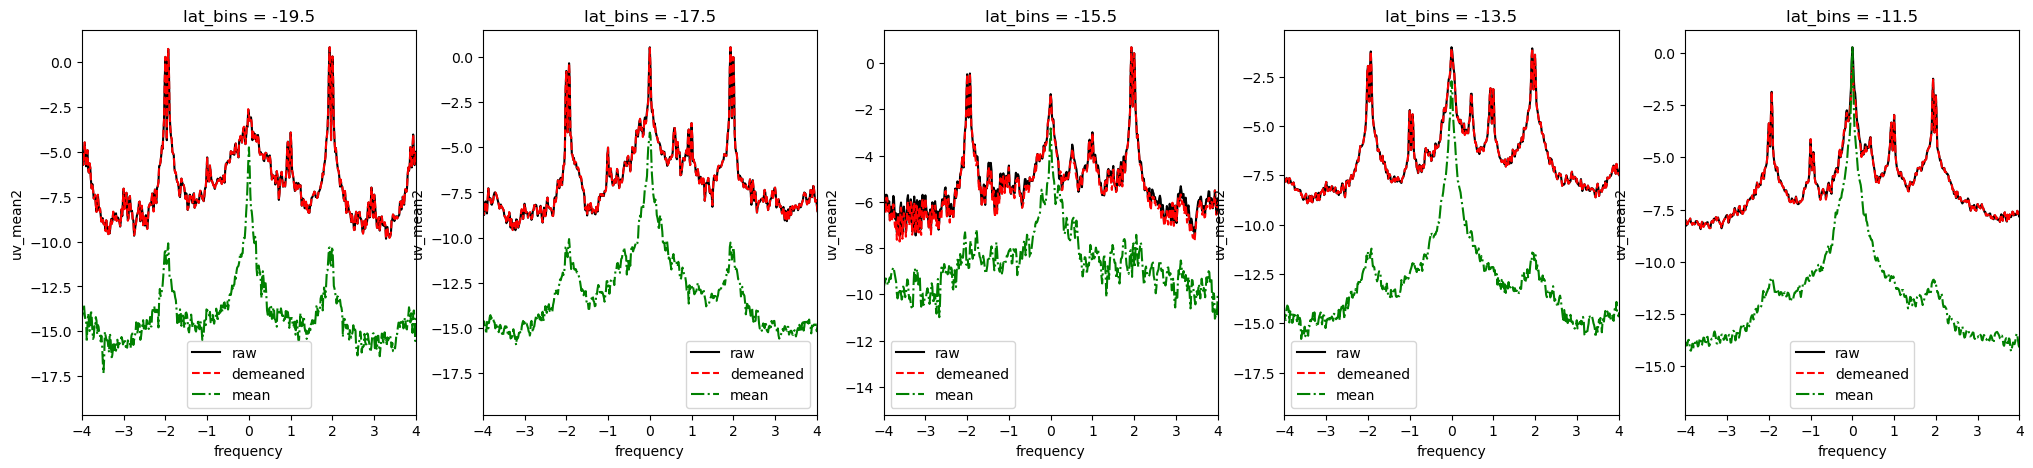

In [69]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_NWA.lat_bins.values[::2]),figsize=(len(ds_NWA.lat_bins.values[::2])*5,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    for l,ax in zip(ds_NWA.lat_bins.values[::2],axs):
    
        np.log(ds_NWA[V].sel(lat_bins=l)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

In [7]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
